### RNN(Recurrent Neural Network) : 순환 신경망
#### 순서가 있는 시퀀스 데이터, time series data(시계열 데이터)를 입력하여 예측

### RNN 계층 구현

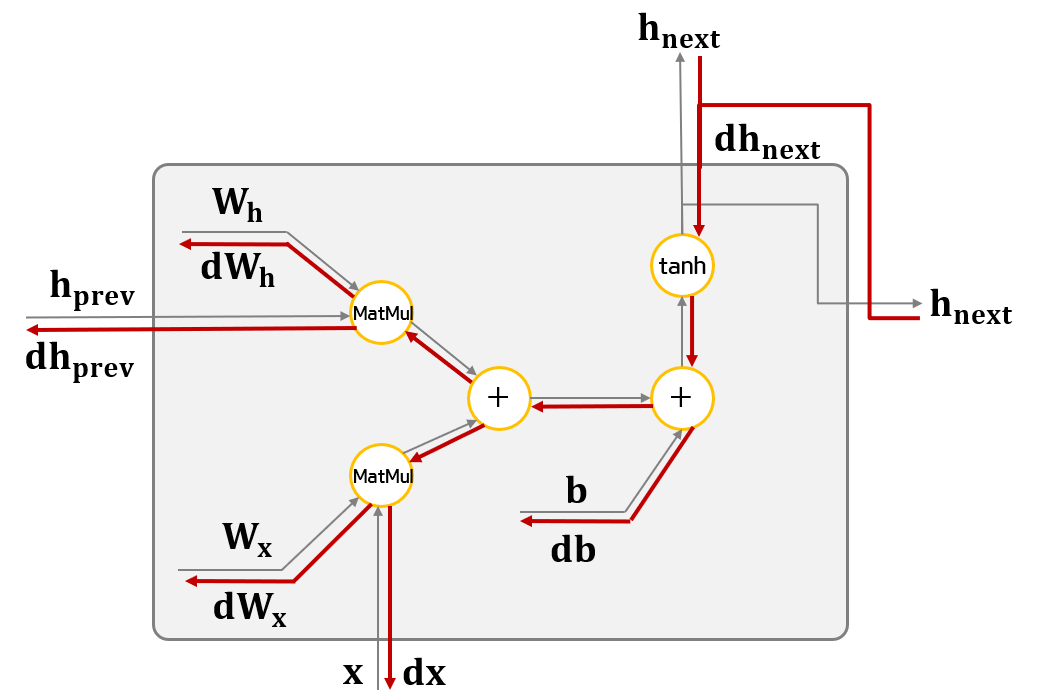

In [1]:
import numpy as np

class RNN :
    def __init__(self, Wx, Wh, b):
        self.params = [Wx,Wh,b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
        
    def forward(self, x, h_prev) :
        Wx,Wh,b = self.params
        t = np.dot(h_prev,Wh) + np.dot(x,Wx) + b
        h_next = np.tanh(t)
        
        self.cache = (x,h_prev,h_next)
        return h_next
    
    def backward(self,dh_next):
        Wx,Wh,b = self.params
        x,h_prev,h_next = self.cache
        
        dt =  dh_next*(1 - h_next**2)    # y = tanh(x)의 미분 : (1 - y^2)     
        db = np.sum(dt, axis=0)          # repeat노드의 역전파 : sum()
        
        dWh = np.dot(h_prev.T,dt)        # matmul의 역전파
        dh_prev = np.dot(dt,Wh.T)
        
        dWx = np.dot(x.T, dt)            # matmul의 역전파
        dx = np.dot(dt,Wx.T)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        return dx, dh_prev

0.9999999999999999
1.0


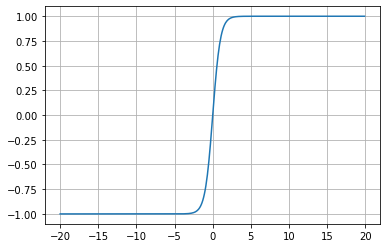

In [2]:
# tanh() 함수 : Hyperbolic Tangent(tanh)
# Hyperbolic Tangent 함수는 확장 된 시그모이드 함수이다
# tanh와 Sigmoid의 차이점은 Sigmoid의 출력 범위가 0에서 1 사이인 반면 tanh와 출력 범위는 -1에서 1사이라는 점이다
# Sigmoid와 비교하여 tanh와는 출력 범위가 더 넓고 경사면이 큰 범위가 더 크기 때문에 더 빠르게 수렴하여 학습하는 특성이 있다
# http://taewan.kim/post/tanh_diff/

import matplotlib.pyplot as plt
x = np.arange(-200,200)
x = x / 10
y = np.tanh(x)

plt.plot(x,y)
plt.grid(True)

print(np.tanh(19))
print(np.tanh(20))

# Time RNN 계층 구현 : T개의 RNN 계층으로 구성

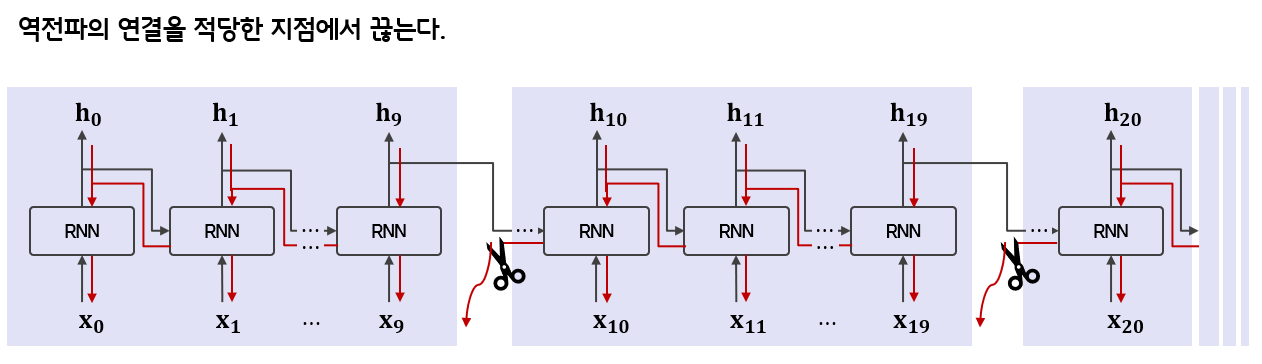

<img src="https://cloud.githubusercontent.com/assets/901975/23348727/cc981856-fce7-11e6-83ea-4b187473466b.png" width="700">

<img src="https://cloud.githubusercontent.com/assets/901975/23383681/9943a9fc-fd82-11e6-8121-bd187994e249.png" width="700">

In [3]:
# TimeRNN 클래스 : Truncated BPTT 
class TimeRNN :
    def __init__(self,Wx, Wh, b, stateful=False):
        self.params = [Wx,Wh,b]
        self.grads = [np.zeros_like(Wx),np.zeros_like(Wh),np.zeros_like(b)]
        self.layers = None             # RNN층을 리스트로 저장
        
        self.h, self.dh = None,None    # h는 forwward() 호출 시 은닉상태를 저장,
                                       # dh는 backward() 호출 시 앞 블럭의 은닉 상태의 기울기를 저장
        self.statuful = stateful       # RNN 계층 사이에서 은닉 상태를 인계한다
        
    def set_state(self,h):
        self.h = h
    
    def reset_state(self):
        self.h = None
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape          # N : batch size, T : sequence length , D : input size
        D, H = Wx.shape             # D : input size, H : hidden size
        
        self.layers = []
        hs = np.empty((N,T,H),dtype='f')  # (N,T,D) -> (N,D) * (D,H) ==>(N,H) --> (N,T,H) 
        
        if not self.statuful or self.h is None:
            self.h = np.zeros((N,H), dtype='f')
            
        for t in range(T):                # T : sequence length, RNN갯수
            layer = RNN(*self.params)     # tuple 인수, (Wx, Wh, b)를 튜플 인수로 전달, 
            self.h = layer.forward(xs[:,t,:], self.h) # t: rnn cell 번호, 0,1,2,....
                                                      # self.h 는 hidden layer의 상태값을 저장
            hs[:,t,:] = self.h
            self.layers.append(layer)
            
        return hs  # 출력 : (N,T,H) 3차원
    
    def backward(self,dhs):
        Wx, Wh, b = self.params
        N, T, D = dhs.shape  
        D, H = Wx.shape
        
        dxs = np.empty((N,T,D),dtype='f')
        dh = 0          # Truncated BPTT : 역전파의 전달이 Time 범위 내에서만 전달된다
        grads = [0,0,0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx,dh = layer.backward(dhs[:,t,:] + dh)  # (N,T,H) 에서 (N,H)추출, 분기노드이므로 dh를 합한다
            dxs[:,t,:] = dx
            
            for i,grad in enumerate(layer.grads):  # 기울기 합산
                grads[i] += grad
                
        for i,grad in enumerate(grads) :
            self.grads[i][...] = grad
        self.dh = dh
        
        return dxs

In [4]:
A = np.empty(10)  # 새로운 메모리에 요소 값을 초기화 하지 않고 배열 생성하여 실행 속도가 빠름
print(A)
B = np.zeros(12)  # '0'으로 모두 초기화하여 실행 속도가 느림
print(B)
B = np.empty(12)
print(B)

[ 38.08363636  62.79272727  87.50181818 112.21090909 136.92
 161.62909091 186.33818182 211.04727273 235.75636364 241.64      ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [5]:
def func(Wx, Wh, b):
    print(Wx, Wh, b)
    
params =[10,20,30]    
func(*params)  # 튜플인수 : * 사용 , 가변 인수

params ={'Wx':100,'Wh':200,'b':300}    
func(**params) # 사전인수 : ** 사용 , 키워드 인수

func(Wx=1,Wh=2,b=3)

10 20 30
100 200 300
1 2 3


In [6]:
from nn_layers import Embedding, Adam, SGD

In [7]:
# TimeEmbedding 클래스
# nn_layers.py 에 추가하여 사용한다

class TimeEmbedding:
    def __init__(self,W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W
    
    def forward(self,xs):  # N : batch size, T : sequence length
        N,T = xs.shape
        V,D = self.W.shape  # V : Hidden size, 사용되지 않음  , D : RNN input size
        
        out = np.empty((N,T,D),dtype='f')   # W:(V,D) -> xs:(N,T) ==> (N,T,D)
        self.layers = []
        
        for t in range(T):
            layer = Embedding(self.W)
            out[:,t,:] = layer.forward(xs[:,t])
            self.layers.append(layer)
            
        return out  # RNN 계층으로 입력, (N,T,D) 3차원  
    
    def backward(self, dout) :
        N, T, D = dout.shape
        
        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:,t,:])
            grad += layer.grads[0]
        
        self.grads[0][...] = grad
        return None              

In [8]:
# TimeAffine 계층
# nn_layers.py 에 추가하여 사용한다

class TimeAffine:
    def __init__(self,W,b):
        self.params = [W,b]
        self.grads = [np.zeros_like(W),np.zeros_like(b)]
        self.x = None
        
    def forward(self,x):
        N,T,D = x.shape   # N : batch size, T : sequence length , D : Affine input size,RNN의 출력사이즈
        W,b = self.params
        
        rx = x.reshape(N*T,-1)  # 2차원으로 변경하여 내적 곱
        out = np.dot(rx,W) + b
        self.x = x
        
        return out.reshape(N,T,-1) # 3차원으로 변경하여 출력

    def backward(self, dout):  # dout : 3차원
        x = self.x
        N, T, D = x.shape
        W, b = self.params
        
        dout = dout.reshape(N*T, -1)  #  2차원으로 변경
        rx = x.reshape(N*T,-1)        #  2차원으로 변경
        
        db = np.sum(dout,axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout,W.T)
        dx = dx.reshape(*x.shape)  # 튜플 가변인수,(N,T,D)
        
        self.grads[0][...] = dW
        self.grads[1][...] = db
        
        return dx        

In [9]:
# TimeSoftmaxWithLoss 계층
# nn_layers.py 에 추가하여 사용한다

class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1

    def softmax(self,x):
        if x.ndim == 2:
            x = x - x.max(axis=1, keepdims=True)
            x = np.exp(x)
            x /= x.sum(axis=1, keepdims=True)
        elif x.ndim == 1:
            x = x - np.max(x)
            x = np.exp(x) / np.sum(np.exp(x))

        return x        

    def forward(self, xs, ts):
        N, T, V = xs.shape

        if ts.ndim == 3:  # 정답 레이블이 원핫 벡터인 경우
            ts = ts.argmax(axis=2)

        mask = (ts != self.ignore_label)  # label 이 -1이 아닌 값만 True 가  되는 2차원 배열을 생성

        # 배치용과 시계열용을 정리(reshape)
        xs = xs.reshape(N * T, V)   # 2차원으로
        ts = ts.reshape(N * T)      # 1차원으로
        mask = mask.reshape(N * T)  # 1차원으로 

        ys = self.softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask                # ignore_label(-1)에 해당하는 데이터는 손실을 0으로 설정
        loss = -np.sum(ls)        # T개의 loss를 합한다
        loss /= mask.sum()        # 평균

        self.cache = (ts, ys, mask, (N, T, V))
        return loss

    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache

        dx = ys        # softmax의 출력 값과
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_label(-1)에 해당하는 데이터는 기울기를 0으로 설정, mask를 2차원으로 변경하여 곱해줌

        dx = dx.reshape((N, T, V)) # 다시 3차원으로 변경

        return dx

In [10]:
a = np.newaxis
print(a)      # np.newaxis ==> None

x1 = np.arange(25)
print(x1)
x2 = x[:,np.newaxis]   # x[:,None], shape을 (25,)에서 (25,1)로 2차원 으로 변경
print(x2)
x3 = x.reshape(-1,1)   # 동일한 결과
print(x3)

None
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
[[-20. ]
 [-19.9]
 [-19.8]
 [-19.7]
 [-19.6]
 [-19.5]
 [-19.4]
 [-19.3]
 [-19.2]
 [-19.1]
 [-19. ]
 [-18.9]
 [-18.8]
 [-18.7]
 [-18.6]
 [-18.5]
 [-18.4]
 [-18.3]
 [-18.2]
 [-18.1]
 [-18. ]
 [-17.9]
 [-17.8]
 [-17.7]
 [-17.6]
 [-17.5]
 [-17.4]
 [-17.3]
 [-17.2]
 [-17.1]
 [-17. ]
 [-16.9]
 [-16.8]
 [-16.7]
 [-16.6]
 [-16.5]
 [-16.4]
 [-16.3]
 [-16.2]
 [-16.1]
 [-16. ]
 [-15.9]
 [-15.8]
 [-15.7]
 [-15.6]
 [-15.5]
 [-15.4]
 [-15.3]
 [-15.2]
 [-15.1]
 [-15. ]
 [-14.9]
 [-14.8]
 [-14.7]
 [-14.6]
 [-14.5]
 [-14.4]
 [-14.3]
 [-14.2]
 [-14.1]
 [-14. ]
 [-13.9]
 [-13.8]
 [-13.7]
 [-13.6]
 [-13.5]
 [-13.4]
 [-13.3]
 [-13.2]
 [-13.1]
 [-13. ]
 [-12.9]
 [-12.8]
 [-12.7]
 [-12.6]
 [-12.5]
 [-12.4]
 [-12.3]
 [-12.2]
 [-12.1]
 [-12. ]
 [-11.9]
 [-11.8]
 [-11.7]
 [-11.6]
 [-11.5]
 [-11.4]
 [-11.3]
 [-11.2]
 [-11.1]
 [-11. ]
 [-10.9]
 [-10.8]
 [-10.7]
 [-10.6]
 [-10.5]
 [-10.4]
 [-10.3]
 [-10.2]
 [-10.1]
 [-10. ]
 [ -9.9]

### RNN Language Model (RNNLM) 구현

In [11]:
class SimpleRnnlm:
    def __init__(self,vocab_size, wordvec_size,hidden_size ):
        V,D,H = vocab_size, wordvec_size,hidden_size
        rn = np.random.randn
        
        # 가중치 초기화
        embed_W = (rn(V,D) / 100).astype('f')       # Embediing 계층의 출력 (N,D)
        rnn_Wx = (rn(D,H) / np.sqrt(D)).astype('f') # Xavier(=Glorot) Initializer, https://gomguard.tistory.com/184
        rnn_Wh = (rn(H,H) / np.sqrt(H)).astype('f') # Xavier(=Glorot) Initializer, https://gomguard.tistory.com/184
        rnn_b = np.zeros(H).astype('f')             # RNN 계층의 출력 : (N,T,H)
        affine_W = (rn(H,V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx,rnn_Wh,rnn_b,stateful=True),
            TimeAffine(affine_W,affine_b)            
        ]
        self.loss_layer = TimeSoftmaxWithLoss() 
        self.rnn_layer = self.layers[1]
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params,self.grads = [],[]
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self,xs,ts):
        for layer in self.layers : # 3회
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs,ts)
        return loss
    
    def backward(self,dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers): # 3회
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.rnn_layer.reset_state()

In [12]:
m = SimpleRnnlm(1,2,3)
m.layers, m.loss_layer

([<__main__.TimeEmbedding at 0x1e56134c508>,
 <__main__.TimeSoftmaxWithLoss at 0x1e56134c808>)

### RNNLM의 학습 코드

In [13]:
from dataset import ptb
import matplotlib.pyplot as plt

# 하이퍼 파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 5      # Truncated BPTT가 한 번에 펼치는 시간 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기(전체 중 1000개만)
corpus, word_to_id,id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size =  int(max(corpus) + 1)  # 418

xs = corpus[:-1]  # 입력 값, 마지막 단어를 제외
ts = corpus[1:]   # 출력 값(정답레이블), 첫 단어를 제외

data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수: %d, 입력 데이터 크기: %d'%(corpus_size,vocab_size,data_size))

# 학습 시 사용하는 변수
max_iters = data_size// (batch_size* time_size) 
print(max_iters)  # 19
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

말뭉치 크기: 1000, 어휘 수: 418, 입력 데이터 크기: 999
19


In [14]:
# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size,hidden_size) # 418, 100, 100
optimizer = SGD(lr)

# 미니배치의 각 샘플의 읽기 시작 위치를 계산
jump = (corpus_size - 1) // batch_size            # 999//10 = 99
offsets = [i * jump for i in range(batch_size)]   # [0, 99, 198, 297, 396, 495, 594, 693, 792, 891]

# max_epoch = 1

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # 미니배치 취득
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]  # xs[(0+0)%999], xs[(0+99)%999]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
                # print('i:',i,'t:',t,'offset..:',(offset + time_idx) % data_size)
            time_idx += 1
            # print('-'*50)
        #print('='*60)    
        
        # 기울기를 구하여 매개변수 갱신  
        loss = model.forward(batch_x,batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1
        
    # epoch 마다 퍼플렉서티 평가  , PPL : perplexity,혼란도,작을수록 좋다,최소 1 , e**L
    ppl = np.exp(total_loss/loss_count)
    print('| 에폭 %d | 퍼플렉서티 %.2f'%(epoch+1,ppl))
    
    ppl_list.append(float(ppl))
    total_loss,loss_count = 0,0

| 에폭 1 | 퍼플렉서티 395.66
| 에폭 2 | 퍼플렉서티 270.32
| 에폭 3 | 퍼플렉서티 223.40
| 에폭 4 | 퍼플렉서티 214.32
| 에폭 5 | 퍼플렉서티 205.64
| 에폭 6 | 퍼플렉서티 203.30
| 에폭 7 | 퍼플렉서티 198.99
| 에폭 8 | 퍼플렉서티 196.47
| 에폭 9 | 퍼플렉서티 190.94
| 에폭 10 | 퍼플렉서티 192.76
| 에폭 11 | 퍼플렉서티 189.92
| 에폭 12 | 퍼플렉서티 192.73
| 에폭 13 | 퍼플렉서티 190.43
| 에폭 14 | 퍼플렉서티 190.65
| 에폭 15 | 퍼플렉서티 190.35
| 에폭 16 | 퍼플렉서티 186.59
| 에폭 17 | 퍼플렉서티 184.47
| 에폭 18 | 퍼플렉서티 181.34
| 에폭 19 | 퍼플렉서티 182.57
| 에폭 20 | 퍼플렉서티 183.76
| 에폭 21 | 퍼플렉서티 181.64
| 에폭 22 | 퍼플렉서티 177.58
| 에폭 23 | 퍼플렉서티 174.13
| 에폭 24 | 퍼플렉서티 176.80
| 에폭 25 | 퍼플렉서티 173.40
| 에폭 26 | 퍼플렉서티 173.41
| 에폭 27 | 퍼플렉서티 167.72
| 에폭 28 | 퍼플렉서티 166.90
| 에폭 29 | 퍼플렉서티 164.46
| 에폭 30 | 퍼플렉서티 159.41
| 에폭 31 | 퍼플렉서티 160.12
| 에폭 32 | 퍼플렉서티 154.18
| 에폭 33 | 퍼플렉서티 155.11
| 에폭 34 | 퍼플렉서티 149.72
| 에폭 35 | 퍼플렉서티 149.76
| 에폭 36 | 퍼플렉서티 143.01
| 에폭 37 | 퍼플렉서티 138.12
| 에폭 38 | 퍼플렉서티 134.96
| 에폭 39 | 퍼플렉서티 129.60
| 에폭 40 | 퍼플렉서티 125.29
| 에폭 41 | 퍼플렉서티 124.97
| 에폭 42 | 퍼플렉서티 119.03
| 에폭 43 | 퍼플렉서티 113.08
| 에폭 44 | 퍼플렉서티 108.

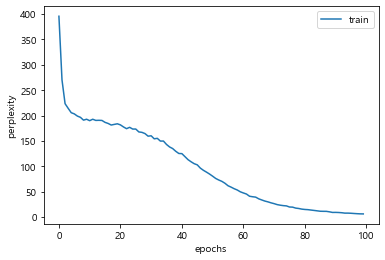

In [15]:
# 그래프 출력
x = np.arange(len(ppl_list))
plt.plot(x,ppl_list,label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.legend()
plt.show()

### RNNLM의 Trainer 클래스

In [16]:
# nn_layers.py 에 추가하여 사용한다
import time

class RnnlmTrainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.time_idx = None
        self.ppl_list = None
        self.eval_interval = None
        self.current_epoch = 0

    def get_batch(self, x, t, batch_size, time_size):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')

        data_size = len(x)
        jump = data_size // batch_size
        offsets = [i * jump for i in range(batch_size)]  # 배치에서 각 샘플을 읽기 시작하는 위치

        for time in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, time] = x[(offset + self.time_idx) % data_size]
                batch_t[i, time] = t[(offset + self.time_idx) % data_size]
            self.time_idx += 1
        return batch_x, batch_t

    def fit(self, xs, ts, max_epoch=10, batch_size=20, time_size=35,
            max_grad=None, eval_interval=20):
        data_size = len(xs)
        max_iters = data_size // (batch_size * time_size)
        self.time_idx = 0
        self.ppl_list = []
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            for iters in range(max_iters):
                batch_x, batch_t = self.get_batch(xs, ts, batch_size, time_size)

                # 기울기를 구해 매개변수 갱신
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 공유된 가중치를 하나로 모음
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 퍼플렉서티 평가
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    ppl = np.exp(total_loss / loss_count)
                    elapsed_time = time.time() - start_time
                    print('| 에폭 %d |  반복 %d / %d | 시간 %d[s] | 퍼플렉서티 %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, ppl))
                    self.ppl_list.append(float(ppl))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = np.arange(len(self.ppl_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.ppl_list, label='train')
        plt.xlabel('반복 (x' + str(self.eval_interval) + ')')
        plt.ylabel('퍼플렉서티')
        plt.show()

def remove_duplicate(params, grads):
    '''
    매개변수 배열 중 중복되는 가중치를 하나로 모아
    그 가중치에 대응하는 기울기를 더한다.
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 가중치 공유 시
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 경사를 더함
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 가중치를 전치행렬로 공유하는 경우(weight tying)
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads
        

| 에폭 1 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 416.69
| 에폭 2 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 384.43
| 에폭 3 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 267.00
| 에폭 4 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 221.86
| 에폭 5 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 209.01
| 에폭 6 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 208.13
| 에폭 7 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 199.79
| 에폭 8 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 200.75
| 에폭 9 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 194.44
| 에폭 10 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 189.81
| 에폭 11 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 192.16
| 에폭 12 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 189.00
| 에폭 13 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 192.35
| 에폭 14 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 186.20
| 에폭 15 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 185.73
| 에폭 16 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 188.09
| 에폭 17 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 187.05
| 에폭 18 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 182.76
| 에폭 19 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 180.13
| 에폭 20 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 180.77
| 에폭 21 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 176.58
| 에폭 22 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 177.

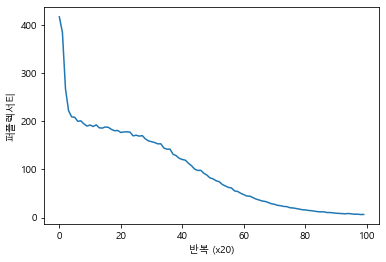

In [17]:
from dataset import ptb
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')

# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 5  # RNN을 펼치는 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000  # 테스트 데이터셋을 작게 설정
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)
xs = corpus[:-1]  # 입력
ts = corpus[1:]  # 출력（정답 레이블）

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)
trainer.plot()